In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from proj1_helpers import *
%load_ext autoreload
%autoreload 2

In [2]:
def jet_num_split(data_path, sub_sample = False):
    """ jet_num is feature number 22 (starting counting at 0)
        returns 1) the data with jet_num <= 1 and 2) the data with jet_num >1
        4 5 6 23 24 25 26 27"""
    yb, input_data, ids = load_csv_data(data_path,sub_sample = False)
    bool_mask = (input_data[:,22]<=1)

    return yb[bool_mask], input_data[bool_mask], ids[bool_mask], yb[np.invert(bool_mask)], input_data[np.invert(bool_mask)], ids[np.invert(bool_mask)]

def remove_useless_features(input_data_jetnum_inf1):
    useless_features_index = [4,5,6,23,24,25,26,27,28]
    mask = np.ones(int(input_data_jetnum_inf1.shape[1]), dtype=bool)
    print mask.shape
    mask[(useless_features_index)] = False
    return input_data_jetnum_inf1[:,mask]

yb_inf1, input_data_inf1, ids_inf1, yb_sup1, input_data_sup1, ids_sup1 = jet_num_split("train.csv", sub_sample = False)
input_data_inf1 = remove_useless_features(input_data_inf1)

(30L,)


In [128]:
print input_data_sup1.shape


(72543L, 30L)


In [3]:
"""sépare les données en 80/20 pour test et train
   retourne les données de train (3) puis les données de test (3)"""
def data_spliting(yb, input_data, ids):

    n = int(yb.shape[0])
    yb_test, input_data_test, ids_test = yb[:50000:], input_data[:50000:], ids[:50000:]
    yb_train, input_data_train, ids_train = yb[50000::], input_data[50000::], ids[50000::]
    return yb_train, input_data_train, ids_train, yb_test, input_data_test, ids_test


In [3]:
def ridge(yb_test, input_data_test, yb_train, input_data_train,lambda_):
    w, train_loss = ridge_regression(yb_train, input_data_train, lambda_)
    #w, train_loss = least_squares_GD(yb_train, input_data_train, np.random.rand(int(input_data_train.shape[1])), 100, 0.0001,computeLoss = True)
    test_loss = compute_loss(yb_test, input_data_test, w)
    y_pred = predict_labels(w, input_data_test)
    return w, train_loss, test_loss, y_pred


In [4]:
""" Générateur renvoyant (en k fois) des données splitées pour train et test
    Retourne les données de train puis de test"""
def K_split_LS(yb,input_data,ids,k):
    n = int(yb.shape[0])
    bool_mask = np.ones(n,dtype=bool)
    bool_mask[::k] = 0
    """On renvoie ... train puis ... test"""
    for i in range(k):
        yield yb[bool_mask], input_data[bool_mask], ids[bool_mask], yb[np.invert(bool_mask)], input_data[np.invert(bool_mask)], ids[np.invert(bool_mask)]
        bool_mask[i::k] = 1
        bool_mask[i+1::k] = 0

In [7]:
def Kfold_ridge(k,degree,lambda_):

    train_loss_list = []
    test_loss_list = []
    score_list = []
    for yb_train, input_data_train, ids_train, yb_test, input_data_test, ids_test in K_split_LS(yb_sup1, input_data_sup1, ids_sup1,k):
        input_data_train_poly = build_poly(input_data_train,degree)
        input_data_test_poly = build_poly(input_data_test,degree)
        w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test_poly, yb_train, input_data_train_poly,lambda_)
        train_loss_list+=[train_loss]
        test_loss_list+=[test_loss]
        score_list+=[np.mean(y_pred == yb_test)]
        
    return train_loss_list, test_loss_list,score_list  

In [8]:
def CrossVal_ridge(k,degree,lambda_):

    yb_train, input_data_train, ids_train, yb_test, input_data_test, ids_test = data_spliting(yb, input_data, ids)
    
    input_data_train_poly = build_poly(input_data_train,degree)
    input_data_test_poly = build_poly(input_data_test,degree)
    
    w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test_poly, yb_train, input_data_train_poly,lambda_)

        
    return [train_loss], [test_loss], [np.mean(y_pred == yb_test)]

In [5]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

Degree 2 done
Degree 3 done
Degree 4 done
Degree 5 done
Degree 6 done
Degree 7 done
Degree 8 done


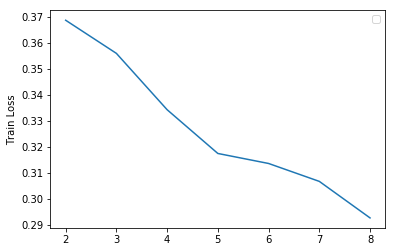

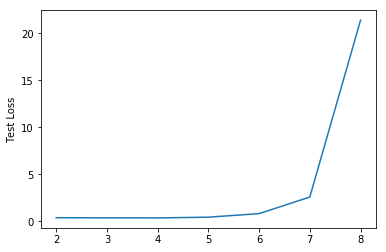

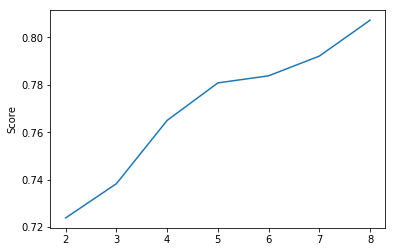

([0.3685645886294404,
  0.3558370226509333,
  0.3341965045970642,
  0.31739205609329535,
  0.3135473198197293,
  0.3066700783275479,
  0.2926356874694556],
 [0.36939075395626614,
  0.35893659814682854,
  0.34849686350756814,
  0.4270295409186889,
  0.8053382050086304,
  2.5715908785645345,
  21.407776681022536],
 [0.7237776272868868,
  0.7382380138850648,
  0.7649531967628498,
  0.7808058844218555,
  0.7837971569002449,
  0.792123226957935,
  0.8072728105332982])

In [9]:
def param_test(k,max_deg,max_lambda,lambda_step):
    lambda_list = np.arange(0,max_lambda,lambda_step)
    #lambda_list = np.logspace(1, 5, num=6)
    degree_list = np.arange(2,max_deg)
    final_train_loss_list = []
    final_test_loss_list = []
    final_score_list = []
    
    lambda_ = 10
    
    for degree in degree_list:
        train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
        #train_loss_list, test_loss_list,score_list = CrossVal_ridge(k,degree,lambda_)
        train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
        final_train_loss_list+=[train_loss]
        final_test_loss_list+=[test_loss]
        final_score_list+=[score]
        print("Degree " + str(degree) + " done")
    """
    degree = 4
    for lambda_ in lambda_list:
        train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
        train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
        final_train_loss_list+=[train_loss*(1./degree)]
        final_test_loss_list+=[test_loss*(1./degree)]
        final_score_list+=[score]
        print("Lambda =  " + str(lambda_) + " done")
    """
    plt.legend()
    plt.figure(1)  
    plt.plot(degree_list,final_train_loss_list)
    plt.ylabel("Train Loss")
    plt.figure(2)
    plt.plot(degree_list,final_test_loss_list)
    plt.ylabel("Test Loss")
    plt.figure(3)
    plt.plot(degree_list,final_score_list)
    plt.ylabel("Score")
    plt.show()
    
    return final_train_loss_list, final_test_loss_list, final_score_list


def param_test_simultane(k,max_deg,max_lambda,number_lambda):
    lambda_list = np.linspace(10,max_lambda,number_lambda)
    #lambda_list = np.logspace(1, 5, num=5)
    degree_list = np.arange(2,max_deg+1)
    
    final_train_loss_list = np.zeros((len(degree_list),number_lambda))
    final_test_loss_list = np.zeros((len(degree_list),number_lambda))
    final_score_list = np.zeros((len(degree_list),number_lambda))
    """
    final_train_loss_list = np.zeros((len(degree_list),5))
    final_test_loss_list = np.zeros((len(degree_list),5))
    final_score_list = np.zeros((len(degree_list),5))
    """
    
    for j,degree in enumerate(degree_list):
        for i, lambda_ in enumerate(lambda_list):
            train_loss_list, test_loss_list,score_list = Kfold_ridge(k,degree,lambda_)
            #train_loss_list, test_loss_list,score_list = CrossVal_ridge(k,degree,lambda_)
            train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
            final_train_loss_list[j,i]=train_loss
            final_test_loss_list[j,i]=test_loss
            final_score_list[j,i]=score
            print "Degree = " + str(degree) + " and Lambda = " + str(lambda_)
    
    
    plt.legend()
    plt.figure(1)
    #plt.contourf(lambda_list,degree_list, final_train_loss_list, 20, cmap='RdGy')
    plt.pcolor(lambda_list,degree_list, final_train_loss_list)
    #plt.colorbar();
    plt.ylabel("Train Loss")
    plt.figure(2)
    plt.contourf(lambda_list,degree_list,  final_test_loss_list, 20, cmap='RdGy')
    plt.colorbar();
    plt.ylabel("Test Loss")
    plt.figure(3)
    plt.contourf(lambda_list,degree_list,  final_score_list, 20, cmap='RdGy')
    plt.colorbar();
    plt.ylabel("Score")
    plt.show()
    
    return final_train_loss_list, final_test_loss_list, final_score_list

param_test(10,9,80,10)


In [142]:
def submission_ridge(degree_inf1,degree_sup1,lambda_inf1,lambda_sup1):
    
    #For the inf1 data
    yb_inf1_test, input_data_inf1_test, ids_inf1_test, yb_sup1_test, input_data_sup1_test, ids_sup1_test = jet_num_split("test.csv")
    input_data_inf1_test = remove_useless_features(input_data_inf1_test)
    input_data_inf1_test_poly = build_poly(input_data_inf1_test, degree_inf1)
    input_data_inf1_poly = build_poly(input_data_inf1,degree_inf1)
    w, train_loss, test_loss, y_pred_inf1 = ridge(yb_inf1_test, input_data_inf1_test_poly, yb_inf1, input_data_inf1_poly,lambda_inf1)
    #For the sup1 data
    input_data_sup1_test_poly = build_poly(input_data_sup1_test, degree_sup1)
    input_data_sup1_poly = build_poly(input_data_sup1,degree_sup1)
    w, train_loss, test_loss, y_pred_sup1 = ridge(yb_sup1_test, input_data_sup1_test_poly, yb_sup1, input_data_sup1_poly,lambda_sup1)
    
    final_ids_test = np.concatenate((ids_inf1_test,ids_sup1_test))
    final_y_pred = np.concatenate((y_pred_inf1,y_pred_sup1))
    create_csv_submission(final_ids_test, final_y_pred, "pred_4_210.csv")
    
submission_ridge(7,9,150,120)    

(30L,)


In [70]:
"""yb_inf1, input_data_inf1, ids_inf1, yb_sup1, input_data_sup1, ids_sup1"""
w, train_loss, test_loss, y_pred = ridge(yb_test, input_data_test, yb, input_data,0)
print w, train_loss, test_loss

[ 8.03494350e-05 -7.20202266e-03 -6.05417273e-03 -5.47559077e-04
 -1.93874687e-02  4.73451613e-04 -2.60379057e-02  3.25106299e-01
 -3.80780015e-05 -2.72785402e+00 -2.21220141e-01  9.50794097e-02
  6.40351607e-02  2.73611370e+00 -3.31801097e-04 -9.54325136e-04
  2.74087044e+00 -5.34165258e-04  9.73498900e-04  3.69225050e-03
  3.54487183e-04 -5.43344617e-04 -3.30448035e-01 -1.40800497e-03
  8.31432840e-04  1.02117276e-03 -1.68047418e-03 -5.83664795e-03
 -1.11088002e-02  2.72831395e+00] 0.3396868094770345 0.9727587947105377


NameError: name 'final_test_loss_list' is not defined